# Introduction to Inverse Problems in Python

## This notebook presents examples illustrating introductory techniques used for image deblurring. 
It is a supporting material for the paper: ``The Image Deblurring Problem: Matrices, Wavelets, and Multilevel Methods,” D. Austin, M. Espanol, M. Pasha, Notices of the American Mathematical Society 69(8), 2022 (forthcoming).

#### Note: For images of large size (for instance, larger than 64), the process of reconstruction is computationally expensive (it takes a long time to be completed). Dimensionality reduction methods are needed to remedy those difficulties.

In [51]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv

##Specify the font
##Latex needs to be installed! If not installed, please comment the following 5 lines
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
plt.rcParams.update(parameters)

## convert a 2-d image into a 1-d vector
def vec(image):
    sh = image.shape
    return image.reshape((sh[0]*sh[1]))

## convert a 1-d vector into a 2-d image of the given shape
def im(x, shape):
    return x.reshape(shape)

## display a 1-d vector as a 2-d image
def display_vec(vec, shape, scale = 1):
    image = im(vec, shape)
    plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
    plt.axis('off')
    plt.show()
    
## write a 1-d vector as a 2-d image file
def save_vec(vec, shape, filename, scale = 1):
    image = im(vec, shape)
    plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    
## a helper function for creating the blurring operator
def get_column_sum(spread):
    length = 40
    raw = np.array([np.exp(-(((i-length/2)/spread[0])**2 + ((j-length/2)/spread[1])**2)/2) 
                    for i in range(length) for j in range(length)])
    return np.sum(raw[raw > 0.0001])

## blurs a single pixel at center with a specified Gaussian spread
def P(spread, center, shape):
    image = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            v = np.exp(-(((i-center[0])/spread[0])**2 + ((j-center[1])/spread[1])**2)/2)
            if v < 0.0001:
                continue
            image[i,j] = v
    return image

## matrix multiplication where A operates on a 2-d image producing a new 2-d image
def image_mult(A, image, shape):
    return im( A @ vec(image), shape)

## construct our vector x_true
def build_x_true():
    dx = 10
    dy = 10
    up_width = 10
    bar_width= 5
    size = 64

    h_im = np.zeros((size, size))
    for i in range(size):
        if i < dy or i > size-dy:
            continue
        for j in range(size):
            if j < dx or j > size - dx:
                continue
            if j < dx + up_width or j > size - dx - up_width:
                h_im[i, j] = 1
            if abs(i - size/2) < bar_width:
                h_im[i, j] = 1

    x_exact = vec(h_im)
    return x_exact

## construct our blurring matrix with a Gaussian spread and zero boundary conditions
def build_A(spread, shape):
    #normalize = get_column_sum(spread)
    m = shape[0]
    n = shape[1]
    A = np.zeros((m*n, m*n))
    count = 0
    for i in range(m):
        for j in range(n):
            column = vec(P(spread, [i, j],  shape))
            A[:, count] = column
            count += 1
    normalize = np.sum(A[:, int(m*n/2 + n/2)])
    A = 1/normalize * A
    return A

# construct regularization matrix of first derivative operator 1D
def FirstDerOperator_1D(n):

    d = np.ones(n-1)
    D = np.diag(d,-1)
    L = np.identity(n)-D
    return L

# construct regularization matrix of first derivative operator 2D
def FirstDerOperator_2D(n):
    L1 = FirstDerOperator_1D(n)
    KP1 = np.kron(np.identity(n), L1)
    KP2 = np.kron(L1, np.identity(n))
    L = np.vstack((KP1, KP2))
    return L

# construct Haar Wavelet transform
def Haar_Wavelet_Transform(n):
    W = np.zeros((n,n))
    knt = 0
    for k in range (0, int(n/2)): 
        W[k][knt] = 1
        W[k][knt+1] = 1        
        W[k+int(n/2)][knt] = 1
        W[k+int(n/2)][knt+1] = -1
        knt=knt+2
    W=(1/np.sqrt(2))*W  
    W1 = W[0:int(n/2),:]
    return W1


## Basic data

Our images will be $64\times64$, and the Gaussian blur has a spatially invariant spread of $(10,10)$.  Then build $\mathbf x^{\rm true}$ and the blurring operator $\mathbf A$.

In [52]:
spread = [10,10]
size = 64
shape = (size, size)
pixels = shape[0] * shape[1]

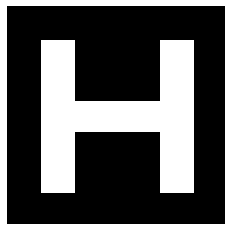

In [53]:
x_true= build_x_true()
save_vec(x_true, shape, 'x_true.png')

The blurring operator is represented by the matrix $\mathbf A$, one column of which is represented below.

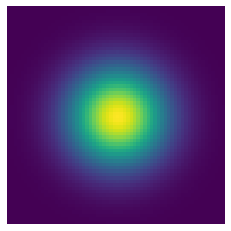

In [54]:
A = build_A(spread, shape)
plt.imshow(im(A[:, int(shape[0]**2/2 + shape[1]/2)], (size, size)))
plt.axis('off')
plt.show()

## Effect on a single pixel

To demonstrate the effect of the blurring operator, a single pixel is fully illuminated in the following image.

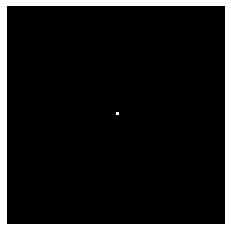

In [55]:
pixel = np.zeros(pixels)
pixel[2016] = 1
save_vec(pixel, shape, 'single-pixel.png')

Now we see the effect of the blurring operator on that one pixel.

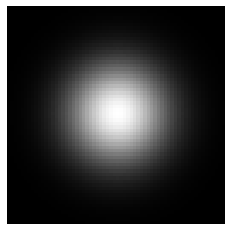

In [56]:
save_vec(A.dot(pixel), shape, 'blurred-pixel.png')

## Construct images

Let's now return to our image ${\mathbf x}^{\rm true}$.

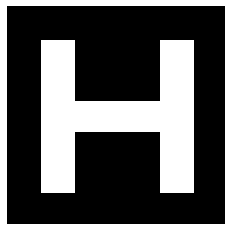

In [57]:
display_vec(x_true, shape)

Blurring ${\mathbf x}^{\rm true}$ results in the image represented by ${\mathbf b}^{\rm true}$.

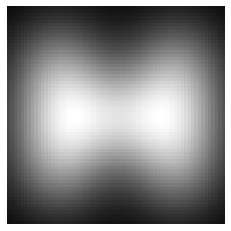

In [58]:
b_true = A @ x_true
save_vec(b_true, shape, 'b_true.png')

## Adding noise

We will consider a couple of different models for how noise is added to the image.

First we'll add some Gaussian noise ${\mathbf e}$ to obtain ${\mathbf b} = {\mathbf e} + {\mathbf b}^{\rm true}$.  The size of the noise is small:  $\|{\mathbf e}\|_2 = 0.001\|{\mathbf b}\|_2$.  

Notice there is no apparent visual difference between ${\mathbf b}$ and ${\mathbf b}^{\rm true}$.

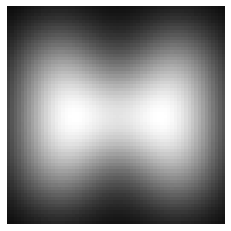

In [59]:
noise = np.random.randn(pixels)
e = 0.001 * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
b = b_true + e
save_vec(b, shape, 'b.png')

We'll now try to reconstruct the original image ${\mathbf x}^{\rm true}$ by solving the equation $\mathbf A{\mathbf x} = {\mathbf b}$.  Notice that the reconstruction bears little resemblence to ${\mathbf x}^{\rm true}$.

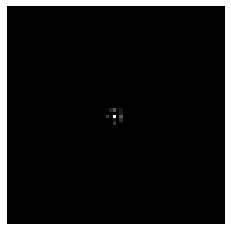

In [60]:
reconstruct = np.linalg.solve(A, b)
diff = np.max(reconstruct) - np.min(reconstruct)         
save_vec(reconstruct, shape, 'x_naive.png')

Some other models of noise include Poisson, Laplace, and salt-and-pepper noise.

In [61]:
def add_noise(b_true, err_lev = 0.01, opt='Gaussian'):
    np.random.seed(1)
    b_true = np.copy(b_true)
    if opt == 'Gaussian':
        mu_obs = np.zeros(pixels)
        sig_obs = err_lev * np.linalg.norm(b_true)/np.sqrt(pixels)
        e_true = np.random.normal(loc=mu_obs, scale=sig_obs*np.ones(pixels))
        b_noise = b_true + e_true
    
    if opt == 'Poisson':
        gamma = 1
        scale = 1000
        b_noise = np.random.poisson(lam=scale*b_true+gamma) / scale
    
    if opt == 'Laplace':
        mu_obs = np.zeros(pixels)
        sig_obs = err_lev * np.linalg.norm(b_true)/np.sqrt(pixels)
        e_true = np.random.laplace(loc=mu_obs, scale=sig_obs*np.ones(pixels))
        b_noise = b_true + e_true
        
    if opt == 'saltpepper':
        np.random.seed(20)
        k = int(np.round(b_true.size*err_lev/2))
        e = np.random.permutation(b_true.size)
        b_noise = np.copy(b_true)
        b_noise[e[1:2*k]] = np.max(b_noise)/32 * np.random.randint(1, 32, 2*k-1)
        
    return b_noise


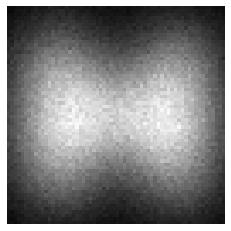

In [62]:
poisson = add_noise(b_true, opt='Poisson')
save_vec(poisson, shape, 'poisson_noise.png')

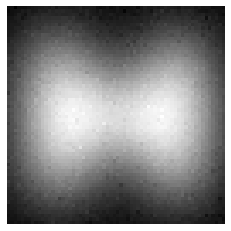

In [63]:
laplace = add_noise(b_true, err_lev=0.02, opt='Laplace')
save_vec(laplace, shape, 'laplace_noise.png')

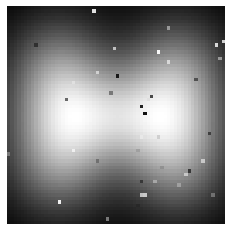

In [64]:
saltpepper = add_noise(b_true, opt='saltpepper')
save_vec(saltpepper, shape, 'saltpepper.png')

## SVD of A

To explain this behavior, let's look at a singular value decomposition of $\mathbf A$.  

Notice how the singular values $\sigma_i$ becomes very small as $i$ grows.  The range of the singular values, roughly spanning $10^{-13}$ to $10^{0}$, explains why the equation $\mathbf A{\mathbf x} = {\mathbf b}$ is ill-conditioned.

In [65]:
import matplotlib

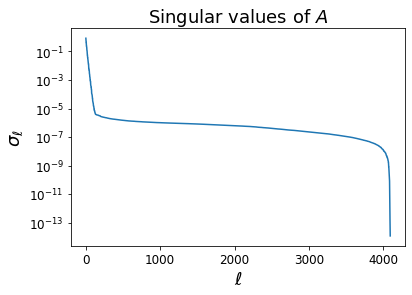

In [66]:
U, S, VT = np.linalg.svd(A)
V = VT.T
plt.semilogy(S)
plt.title('Singular values of $A$')
plt.xlabel('$\ell$')
plt.ylabel('$\sigma_{\ell}$')
plt.savefig('singular_values.png', bbox_inches='tight')
plt.show()

Notice how the components of ${\mathbf b}^{\rm true}$, when expressed in a basis of left singular vectors ${\mathbf u}_i$, roughly follow the singular values $\sigma_i$.  This is an illustration of the *discrete Picard condition.*

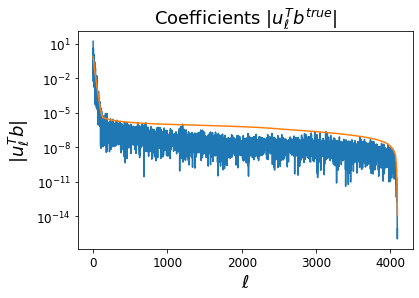

In [90]:
plt.semilogy(np.abs(U.T @ b_true))
plt.semilogy(S)
plt.title('Coefficients $|u_{\ell}^Tb^{true}|$')
plt.xlabel('$\ell$')
plt.ylabel('$|u_{\ell}^Tb|$')
plt.savefig('UTb_true.png', bbox_inches='tight')
plt.show()

We see, however, that the components of ${\mathbf b}$ in this basis remain roughly constant due to the noise contributed by ${\mathbf e}$.

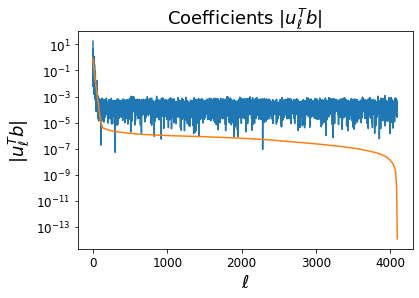

In [68]:
plt.semilogy(np.abs(U.T @ b))
plt.semilogy(S)
plt.title('Coefficients $|u_{\ell}^Tb|$')
plt.ylabel('$|u_{\ell}^Tb|$')
plt.xlabel('$\ell$')
plt.savefig('UTb.png', bbox_inches='tight')
plt.show()

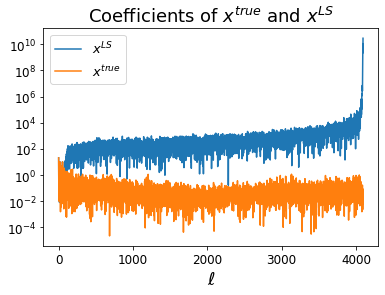

In [69]:
plt.semilogy(np.abs(1/S * (U.T @ b)), label="$x^{LS}$")
plt.semilogy(np.abs(1/S * (U.T @ b_true)), label="$x^{true}$")
plt.title('Coefficients of $x^{true}$ and $x^{LS}$')
plt.xlabel('$\ell$')
plt.legend()
plt.savefig('VTx-ls.png', bbox_inches='tight')
plt.show()

The third condition for a discrete ill-posed problem is that the singular vectors ${\mathbf v}_i$ grow more oscillatory as $i$ grows.  Notice how the singular vectors ${\mathbf v}_i$ with larger $i$ show more oscillatory behavior.

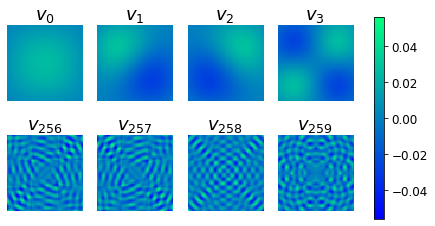

In [70]:
n = 2
m = 4
fig, axes = plt.subplots(n, m)
v_i = [V[:, k] for k in range(m)]
v_i += [V[:, k] for k in range(128, 128+m)]
right_singular = np.array(v_i)
immax = np.max(right_singular)
immin = np.min(right_singular)
k = 0
for i in range(n):
    for j in range(m):
        image = axes[i][j].imshow(im(-V[:, k], (size, size)), vmin=immin, vmax=immax, cmap='winter')
        axes[i][j].axis('off')
        axes[i][j].set_title(r'$v_{' + str(k) + r'}$')
        k += 1
    k = 256
plt.subplots_adjust(bottom=0, top=0.7, left = 0, right=1)
fig.colorbar(image, ax=axes.ravel().tolist())
plt.savefig('v_vectors.png', bbox_inches='tight')
plt.show()

## Tikhonov regularization

We'll now look at the regularized solutions ${\mathbf x}^{\rm reg}$, obtained by Tikhonov regularization, for a range of regularization parameters $\lambda$.  We choose the parameter $\lambda$ that minimizes the difference $\|{\mathbf x}^{\rm true}-{\mathbf x}^{\rm reg}\|_2$.  Of course, this isn't possible in practice since we don't know ${\mathbf x}^{\rm true}$.

The next cell displays ${\mathbf x}^{\rm reg}$ with this optimal parameter.  It also produces the optimal value of $\lambda$ along with the residual $\|\mathbf A{\mathbf x}^{\rm reg} - {\mathbf b}\|_2$ and the norm $\|{\mathbf x}^{\rm reg}\|_2$ for the optimal $\lambda$.

Minima:
Lambda   =  0.000244140625
residual =  0.018013045973643147
error   =  0.37868115245892453
x_norm   =  31.06554202648837


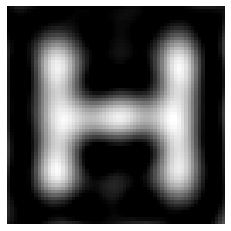

In [71]:
lamb = 1/16
minerror = 10000
lambdas = []
xnorms = []
residuals = []
while lamb > 1e-7:
    F = np.array([s/(s**2 + lamb**2) for s in S])
    x_reg = V @ np.diag(F) @ U.T @ b
    lambdas.append(lamb)
    xnorms.append(np.linalg.norm(x_reg))
    residuals.append(np.linalg.norm(A @ x_reg - b))
    error = np.linalg.norm(x_reg - x_true)/np.linalg.norm(x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        minx = x_reg
        minxnorm = xnorms[-1]
        minresidual = residuals[-1]
    
    lamb /= 2
    
l_curve = list(zip(lambdas, residuals, xnorms))

print('Minima:')
print('Lambda   = ', minlamb)
print('residual = ', minresidual)
print('error   = ', minerror)
print('x_norm   = ', minxnorm)

save_vec(minx, shape, 'x_reg.png')

In [72]:
for i, datum in enumerate(l_curve):
    print(i, datum)

0 (0.0625, 0.45187690026880867, 25.645562308822015)
1 (0.03125, 0.1719421663122519, 27.114343519013726)
2 (0.015625, 0.07488502412956388, 27.89845177084334)
3 (0.0078125, 0.036512550613535165, 28.452447485054023)
4 (0.00390625, 0.025127500927664803, 28.806834232780474)
5 (0.001953125, 0.021055503341172847, 29.236406889254052)
6 (0.0009765625, 0.018682561761068864, 30.0337710949042)
7 (0.00048828125, 0.01810072320557096, 30.676184481156778)
8 (0.000244140625, 0.018013045973643147, 31.06554202648837)
9 (0.0001220703125, 0.017981307905152063, 31.701612489358524)
10 (6.103515625e-05, 0.01795246063622141, 34.01124503863009)
11 (3.0517578125e-05, 0.017915514573627445, 44.37317963632101)
12 (1.52587890625e-05, 0.017837786769723665, 95.40371878157764)
13 (7.62939453125e-06, 0.01762258711146259, 297.4178254071708)
14 (3.814697265625e-06, 0.017017985011659756, 974.3849659005413)
15 (1.9073486328125e-06, 0.015603463543168161, 2880.8767814183493)
16 (9.5367431640625e-07, 0.013214485073648271, 7065

Now we'll construct the $L$-curve, which is a plot of the residual $\|\mathbf A{\mathbf x}^{\rm reg} - {\mathbf b}\|_2$ and norm $\|{\mathbf x}^{\rm reg}\|_2$ as we vary $\lambda$.  Notice that the optimal $\lambda$ occurs when 
$\|\mathbf A{\mathbf x}^{\rm reg} - {\mathbf b}\|_2 =  0.018$ and $\|{\mathbf x}^{\rm reg}\|_2 = 31.1$, which is the corner of the "L".  This provides a means of identifying the optimal regularized solution ${\mathbf x}^{\rm reg}$ when we don't know ${\mathbf x}^{\rm true}$.

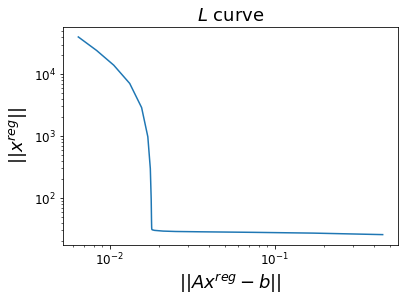

In [73]:
plt.loglog(residuals, xnorms)
plt.title('$L$ curve')
plt.xlabel('$||Ax^{reg} - b||$')
plt.ylabel('$||x^{reg}||$')
plt.savefig('L-curve.png', bbox_inches='tight')
plt.show()

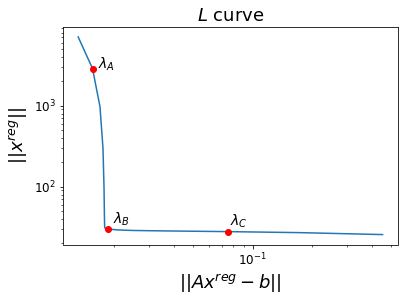

In [74]:
plt.loglog(residuals[:-3], xnorms[:-3])
plt.title('$L$ curve')
plt.xlabel('$||Ax^{reg} - b||$')
plt.ylabel('$||x^{reg}||$')

annotate = [2, 6, 15]
annotate_x = [residuals[p] for p in annotate]
annotate_y = [xnorms[p] for p in annotate]
plt.scatter(annotate_x, annotate_y, color='red', zorder=3, alpha = 1)

plt.text(residuals[annotate[0]] + 0.002, xnorms[annotate[0]]+5, '$\lambda_C$', fontsize=14)
plt.text(residuals[annotate[1]] + 0.001, xnorms[annotate[1]]+5, '$\lambda_B$', fontsize=14)
plt.text(residuals[annotate[2]] + 0.001, xnorms[annotate[2]]+1, '$\lambda_A$', fontsize=14)
plt.savefig('annotated-L-curve.png', bbox_inches='tight')
plt.show()

In [75]:
def filtering_coeffs(lamb):
    return np.array([s**2/(s**2 + lamb**2) for s in S])

def filtered_b_coeffs(lamb, label):
    coeffs = filtering_coeffs(lamb)
    plt.semilogy(coeffs * np.abs(U.T @ b), color='mediumseagreen', label='$\phi_\ell~|u_\ell^Tb|$')
    plt.semilogy(np.abs(U.T @ b), color='cornflowerblue', label='$|u_\ell^Tb|$')
    plt.semilogy(coeffs * np.abs(U.T @ b), color='mediumseagreen', alpha=0.5)
    plt.semilogy([lamb] * size**2, color='red', label='$\lambda_'+label+'$')
    plt.semilogy(S, label='$\sigma_\ell$', color='orange')
    plt.title('Coefficients $|u_\ell^Tb|$ and $\phi_\ell~|u_\ell^Tb|$')
    plt.xlabel('$\ell$')
    plt.legend()
    plt.savefig('filtering_'+label+'.png', bbox_inches='tight')
    plt.show()

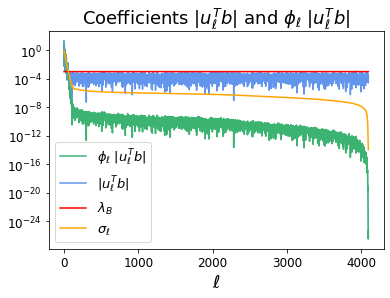

In [76]:
filtered_b_coeffs(lambdas[annotate[1]], 'B')

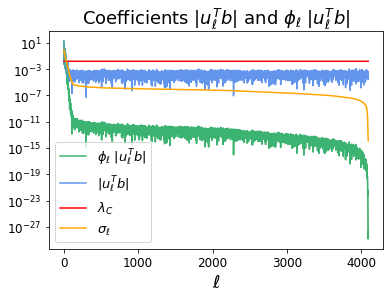

In [77]:
filtered_b_coeffs(lambdas[annotate[0]], 'C')

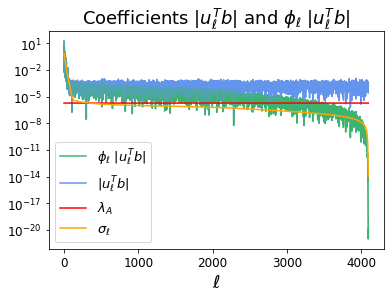

In [78]:
filtered_b_coeffs(lambdas[annotate[2]], 'A')


We now compute the general Tikhonov solution by solving the problem $\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L \mathbf x\|_2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$.

Minima:
Lambda   =  0.00048828125
error   =  0.36676972820291676


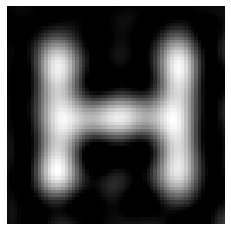

In [79]:
L = FirstDerOperator_2D(shape[0])

lamb = 1/16
minerror = 10000

while lamb > 1e-05:
    xTik = dot( inv( A.T.dot(A) + lamb**2*L.T.dot(L)),( A.T.dot(b)))
    error = np.linalg.norm(xTik - x_true)/np.linalg.norm(x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        mingTik = xTik
    lamb /= 2

print('Minima:')
print('Lambda   = ', minlamb)
print('error   = ', minerror)

save_vec(mingTik, shape, 'xgTik.png')

We now compute the TV solution by solving the problem $\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_1$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. To solve the problem, we apply an Iterative Reweighted Least Squares (IRLS) approach. As you will notice, this takes longer, since it solves many least squares problems.

Minima:
Lambda   =  0.000244140625
error   =  0.20545429552275646


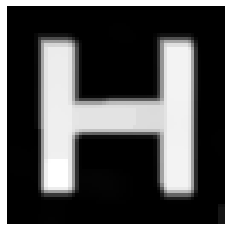

In [80]:
lamb = 1/64
minerror = 10000
maxiter = 10
p = 1

while lamb > 1e-04:
    x = mingTik
    for _ in range(maxiter):
        x_old = x
        w =np.array(abs(L.dot(x_old)))    
        w[w < 0.02] = 0.001  
        W = diag(w)
        W = fractional_matrix_power(W, (p-2))  
        x = dot( inv( A.T.dot(A) + lamb**2*L.T.dot(W).dot(L)), A.T.dot(b) )
        error = np.linalg.norm(x - x_true)/np.linalg.norm(x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        minTV = x
    lamb /= 2

print('Minima:')
print('Lambda   = ', minlamb)
print('error   = ', minerror)
save_vec(minTV, shape, 'xTV.png')

# Wavelets

Let's play  with wavelets a little bit. We will compute the different details that one obtains by computing the wavelet transform of an image. Notice that the "approximation" is a quarter of dimension of the original.

Reference: 
Gregory R. Lee, Ralf Gommers, Filip Wasilewski, Kai Wohlfahrt, Aaron O’Leary (2019). PyWavelets: A Python package for wavelet analysis. Journal of Open Source Software, 4(36), 1237, https://doi.org/10.21105/joss.01237.

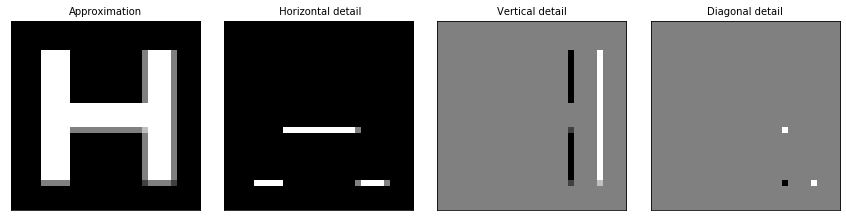

In [81]:
import pywt

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(im(x_true, shape), 'db1')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

Here, we compress the blurry and noisy image $\mathbf b$.

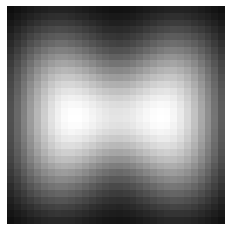

In [82]:
W1 = Haar_Wavelet_Transform(shape[0])
W12D = np.kron(W1,W1)            
bhat = W12D.dot(b)
display_vec(bhat, (32,32))

We compress the operator $\mathbf A$ and solve a compressed system. Notice that the compressed regularized solution has information that can be used without going back to the original dimensions. Of course, resolution has been lost, but it might not matter depending on the application.

Minima:
Lambda   =  0.000244140625
error   =  0.30778481312911155


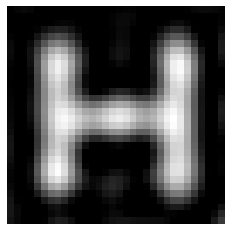

In [83]:
lamb = 1
minerror = 10000
Lhat = FirstDerOperator_2D(32)
Ahat = W12D.dot(A).dot(W12D.T)

while lamb > 1e-05:
    x = dot( inv( Ahat.T.dot(Ahat) + lamb**2*Lhat.T.dot(Lhat)),( Ahat.T.dot(bhat)))
    error = np.linalg.norm(x - vec(LL))/np.linalg.norm(vec(LL))
    if error < minerror:
        minerror = error
        minlamb = lamb
        mingTik_MGM = x
    lamb /= 2

print('Minima:')
print('Lambda   = ', minlamb)
print('error   = ', minerror)

save_vec(mingTik_MGM, (32,32), 'mingTik_MGM.png')

Minima:
Lambda   =  0.00048828125
error   =  0.11329132641033632


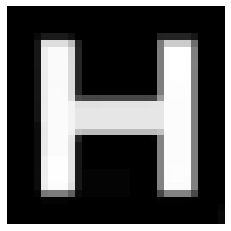

In [84]:
lamb = 1
minerror = 10000
maxiter = 10
p = 1

while lamb > 1e-04:
    x = mingTik_MGM
    for _ in range(maxiter):
        x_old = x
        w =np.array(abs(Lhat.dot(x_old)))    
        w[w < 0.02] = 0.001  
        W = diag(w)
        W = fractional_matrix_power(W, (p-2))  
        x = dot( inv( Ahat.T.dot(Ahat) + lamb**2*Lhat.T.dot(W).dot(Lhat)), Ahat.T.dot(bhat) )
        error = np.linalg.norm(x - vec(LL))/np.linalg.norm(vec(LL))
    if error < minerror:
        minerror = error
        minlamb = lamb
        minTV_MGM = x
    lamb /= 2

print('Minima:')
print('Lambda   = ', minlamb)
print('error   = ', minerror)
save_vec(minTV_MGM, (32,32), 'xTV_MGM.png')

## Illustration for the boundary conditions

In [85]:
#x_true = build_x_true()
#shape = x_true.shape
x_true_mat = im(x_true, shape)
print(x_true_mat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [86]:
#define boundary conditions -- for illustration purposes only
def boundaryConditions(x_true_mat, boundary): ## set boundary to zero or periodic
    sh = x_true_mat.shape
    if boundary == 'periodic':
        x_boundary_2 = np.hstack((x_true_mat, x_true_mat)) # 64 \times 2*64
        x_boundary_3 = np.hstack((x_boundary_2, x_true_mat)) # 64 \times 3*64
        x_boundary_v = np.vstack((x_boundary_3, x_boundary_3))
        x_boundary = np.vstack((x_boundary_v, x_boundary_3))
    elif boundary == 'zero':
        x_temp = np.zeros(sh) #64 \times 64
        x_boundary_1 = np.zeros((64, 3*64)) #64 \times 3*64
        x_boundary_2 = np.hstack((x_temp, x_true_mat)) # 64 \times 2*64
        x_boundary_3 = np.hstack((x_boundary_2, x_temp)) # 64 \times 3*64
        x_boundary_v = np.vstack((x_boundary_1, x_boundary_3))
        x_boundary = np.vstack((x_boundary_v, x_boundary_1))
    return x_boundary

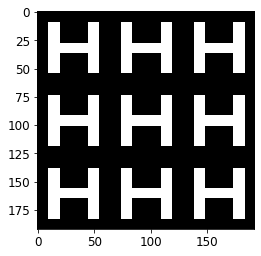

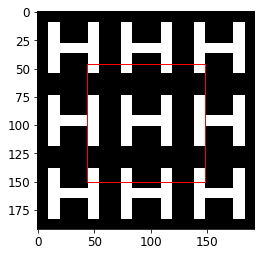

<Figure size 432x288 with 0 Axes>

In [87]:
# build a frame around the image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
nn = 20
x = boundaryConditions(x_true_mat, boundary = 'periodic')
plt.imshow(x, cmap='gray')
fig, ax = plt.subplots(1)
ax.imshow(x, cmap='gray')
rect = patches.Rectangle((64-nn,64-nn+2), 64+2*nn, 64+2*nn, linewidth=1,
                         edgecolor='r', facecolor="none")
ax.add_patch(rect)
plt.show()
plt.savefig('x_boundary_large.png')

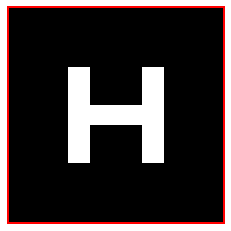

<Figure size 432x288 with 0 Axes>

In [88]:
# cut the image and add the red frame -- zero boundary condition
nn = 20
fig, ax = plt.subplots(1)
x_b = boundaryConditions(x_true_mat, 'zero')
save_vec(x_b, (3*64, 3*64), 'x_b.png')
x_cut = x_b[64-nn+1:(2*64+nn), 64-nn+1:(2*64+nn)]
new_shape = x_cut.shape
save_vec(x_cut, new_shape, 'x_cut.png')
rect = patches.Rectangle((0,0), 64+2*nn-2, 64+2*nn-2, linewidth=2,
                         edgecolor='r', facecolor="none")
ax.add_patch(rect)
plt.show()
plt.savefig('x_cut_frame_zero.png')

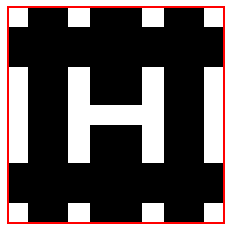

<Figure size 432x288 with 0 Axes>

In [89]:
# cut the image and add the red frame -- periodic boundary condition
nn = 20
fig, ax = plt.subplots(1)
x_b = boundaryConditions(x_true_mat, 'periodic')
save_vec(x_b, (3*64, 3*64), 'x_b.png')
x_cut = x_b[64-nn+1:(2*64+nn), 64-nn+1:(2*64+nn)]
new_shape = x_cut.shape
save_vec(x_cut, new_shape, 'x_cut.png')
rect = patches.Rectangle((0,0), 64+2*nn-2, 64+2*nn-2, linewidth=2,
                         edgecolor='r', facecolor="none")
ax.add_patch(rect)
plt.show()
plt.savefig('x_cut_frame_periodic.png')